<p>
<img src="http://www.cerm.unifi.it/chianti/images/logo%20unifi_positivo.jpg" 
        alt="UniFI logo" style="float: left; width: 20%; height: 20%;">
<div align="right">
Massimo Nocentini<br>
<small>
<br>December 1, 2016: `longest_common_subsequence`
<br>November 29, 2016: `matrix_product_ordering`
<br>November 22, 2016: `edit_distance`
<br>September 21, 2016: Monge arrays
</small>
</div>
</p>
<br>
<div align="center">
<b>Abstract</b><br>
Some examples of *dynamic programming*.
</div>

In [24]:
from functools import lru_cache
import operator
from itertools import count, zip_longest, chain
from collections import OrderedDict
from random import randint

In [2]:
def memo_holder(optimizer):
    def f(*args, **kwds):
        return_memo_table = kwds.pop('memo_table', False)
        pair = optimized, memo_table = optimizer(*args, **kwds)
        return pair if return_memo_table else optimized
    return f

# Monge arrays

Have a look at https://en.wikipedia.org/wiki/Monge_array

In [3]:
def parity_numbered_rows(matrix, parity, include_index=False):
    start = 0 if parity == 'even' else 1
    return [(i, r) if include_index else r 
            for i in range(start, len(matrix), 2)
            for r in [matrix[i]]]
    
def argmin(iterable, only_index=True):
    index, minimum = index_min = min(enumerate(iterable), key=operator.itemgetter(1))
    return index if only_index else index_min

def interleaving(one, another):
    for o, a in zip_longest(one, another):
        yield o
        if a: yield a

def is_sorted(iterable, pred=lambda l, g: l <= g):
    _, *rest = iterable
    return all(pred(l, g) for l, g in zip(iterable, rest))
            
def minima_indexes(matrix):
    
    if len(matrix) == 1: return [argmin(matrix.pop())]
    
    recursion = minima_indexes(parity_numbered_rows(matrix, parity='even'))
    even_minima = OrderedDict((i, m) for i, m in zip(count(start=0, step=2), recursion))
    odd_minima = [argmin(odd_r[start:end]) + start
                  for o, odd_r in parity_numbered_rows(matrix, parity='odd', include_index=True)
                  for start in [even_minima[o-1]]
                  for end in [even_minima[o+1]+1 if o+1 in even_minima else None]]
    
    return list(interleaving(even_minima.values(), odd_minima))

def minima(matrix):
    return [matrix[i][m] for i, m in enumerate(minima_indexes(matrix))]

def is_not_monge(matrix):
    return any(any(matrix[r][m] > matrix[r][i] for i in range(m)) 
               for r, m in enumerate(minima_indexes(matrix)))
    

The following *is* a Monge array:

In [70]:
matrix = [
    [10, 17, 13, 28, 23],
    [17, 22, 16, 29, 23],
    [24, 28, 22, 34, 24],
    [11, 13, 6, 17, 7],
    [45, 44, 32, 37, 23],
    [36, 33, 19, 21, 6],
    [75, 66, 51, 53, 34],
]

minima(matrix)

[10, 16, 22, 6, 23, 6, 34]

In [71]:
minima_indexes(matrix)

[0, 2, 2, 2, 4, 4, 4]

In [72]:
is_not_monge(matrix)

False

The following *is not* a Monge array:

In [73]:
matrix = [
    [37, 23, 22, 32],
    [21, 6, 7, 10],
    [53, 34, 30, 31],
    [32, 13, 9, 6],
    [43, 21, 15, 8],
]

minima(matrix) # produces a wrong answer!!!

[22, 7, 30, 6, 8]

In [74]:
minima_indexes(matrix)

[2, 2, 2, 3, 3]

In [75]:
is_not_monge(matrix)

True

# `longest_increasing_subsequence`

In [35]:
@memo_holder
def longest_increasing_subsequence(seq):

    L = []

    for i, current in enumerate(seq):
        """opt, arg = max([(l, j) for (l, j) in L[:i] if l[-1] < current], 
                       key=lambda p: len(p[0]), 
                       default=([], tuple()))
        L.append(opt + [current], (arg, i))"""
        L.append(max(filter(lambda prefix: prefix[-1] < current, L[:i]), key=len, default=[]) + [current])

    return max(L, key=len), L


def lis_rec(seq):

    @lru_cache(maxsize=None)
    def rec(i):
        current = seq[i]
        return max([rec(j) for j in range(i) if seq[j] < current], key=len, default=[]) + [current]

    return max([rec(i) for i, _ in enumerate(seq)], key=len)



a simple test case taken from page 157:

In [36]:
seq = [5, 2, 8, 6, 3, 6, 9, 7] # see page 157

In [37]:
subseq, memo_table = longest_increasing_subsequence(seq, memo_table=True)

In [38]:
subseq

[2, 3, 6, 9]

memoization table shows that `[2,3,6,7]` is another solution:

In [39]:
memo_table

[[5], [2], [5, 8], [5, 6], [2, 3], [2, 3, 6], [2, 3, 6, 9], [2, 3, 6, 7]]

In [40]:
lis_rec(seq)

[2, 3, 6, 9]

The following is an average case where the sequence is generated randomly:

In [41]:
length = int(5e3)
seq = [randint(0, length) for _ in range(length)]

In [42]:
%timeit longest_increasing_subsequence(seq)

1 loop, best of 3: 3.73 s per loop


In [43]:
%timeit lis_rec(seq)

1 loop, best of 3: 3.06 s per loop


worst scenario where the sequence is a sorted list, in increasing order:

In [44]:
seq = range(length)

In [45]:
%timeit longest_increasing_subsequence(seq)

1 loop, best of 3: 3.94 s per loop


In [46]:
%timeit lis_rec(seq)

1 loop, best of 3: 5.32 s per loop


# `edit_distance`

In [26]:
@memo_holder
def edit_distance(xs, ys, 
                  gap_in_xs=lambda y: 1, # cost of putting a gap in `xs` when reading `y`
                  gap_in_ys=lambda x: 1, # cost of putting a gap in `ys` when reading `x`
                  mismatch=lambda x, y: 1,   # cost of mismatch (x, y) in the sense of `==`
                  gap = '▢',
                  mark=lambda s: s.swapcase(), 
                  reduce=sum):
    
    T = {}
    
    T.update({ (i, 0):(xs[:i], gap * i, i) for i in range(len(xs)+1) })
    T.update({ (0, j):( gap * j,ys[:j], j) for j in range(len(ys)+1) })
    
    def combine(w, z):
        a, b, c = zip(w, z)
        return ''.join(a), ''.join(b), reduce(c)
    
    for i, x in enumerate(xs, start=1):
        for j, y in enumerate(ys, start=1):
             T[i, j] = min(combine(T[i-1, j], (x, gap, gap_in_ys(x))),
                           combine(T[i, j-1], (gap, y, gap_in_xs(y))),
                           combine(T[i-1, j-1], (x, y, 0) if x == y else (mark(x), mark(y), mismatch(x, y))),
                           key=lambda t: t[2])
                
    
    return T[len(xs), len(ys)], T

In [21]:
(xs, ys, cost), memo_table = edit_distance('exponential', 'polynomial', memo_table=True)

In [22]:
print('edit with cost {}:\n\n{}\n{}'.format(cost, xs, ys))

edit with cost 6:

expoNEnT▢ial
▢▢poLYnOmial


In [23]:
memo_table

{(0, 0): ('', '', 0),
 (0, 1): ('▢', 'p', 1),
 (0, 2): ('▢▢', 'po', 2),
 (0, 3): ('▢▢▢', 'pol', 3),
 (0, 4): ('▢▢▢▢', 'poly', 4),
 (0, 5): ('▢▢▢▢▢', 'polyn', 5),
 (0, 6): ('▢▢▢▢▢▢', 'polyno', 6),
 (0, 7): ('▢▢▢▢▢▢▢', 'polynom', 7),
 (0, 8): ('▢▢▢▢▢▢▢▢', 'polynomi', 8),
 (0, 9): ('▢▢▢▢▢▢▢▢▢', 'polynomia', 9),
 (0, 10): ('▢▢▢▢▢▢▢▢▢▢', 'polynomial', 10),
 (1, 0): ('e', '▢', 1),
 (1, 1): ('E', 'P', 1),
 (1, 2): ('E▢', 'Po', 2),
 (1, 3): ('E▢▢', 'Pol', 3),
 (1, 4): ('E▢▢▢', 'Poly', 4),
 (1, 5): ('E▢▢▢▢', 'Polyn', 5),
 (1, 6): ('E▢▢▢▢▢', 'Polyno', 6),
 (1, 7): ('E▢▢▢▢▢▢', 'Polynom', 7),
 (1, 8): ('E▢▢▢▢▢▢▢', 'Polynomi', 8),
 (1, 9): ('E▢▢▢▢▢▢▢▢', 'Polynomia', 9),
 (1, 10): ('E▢▢▢▢▢▢▢▢▢', 'Polynomial', 10),
 (2, 0): ('ex', '▢▢', 2),
 (2, 1): ('Ex', 'P▢', 2),
 (2, 2): ('EX', 'PO', 2),
 (2, 3): ('EX▢', 'POl', 3),
 (2, 4): ('EX▢▢', 'POly', 4),
 (2, 5): ('EX▢▢▢', 'POlyn', 5),
 (2, 6): ('EX▢▢▢▢', 'POlyno', 6),
 (2, 7): ('EX▢▢▢▢▢', 'POlynom', 7),
 (2, 8): ('EX▢▢▢▢▢▢', 'POlynomi', 8),
 (2, 9): ('EX▢

In [49]:
(xs, ys, cost), memo_table = edit_distance('exponential', 'polynomial', memo_table=True, mismatch=lambda x,y: 10)

In [50]:
print('edit with cost {}:\n\n{}\n{}'.format(cost, xs, ys))

edit with cost 9:

expo▢▢n▢▢ential
▢▢polynom▢▢▢ial


In [51]:
memo_table

{(0, 0): ('', '', 0),
 (0, 1): ('▢', 'p', 1),
 (0, 2): ('▢▢', 'po', 2),
 (0, 3): ('▢▢▢', 'pol', 3),
 (0, 4): ('▢▢▢▢', 'poly', 4),
 (0, 5): ('▢▢▢▢▢', 'polyn', 5),
 (0, 6): ('▢▢▢▢▢▢', 'polyno', 6),
 (0, 7): ('▢▢▢▢▢▢▢', 'polynom', 7),
 (0, 8): ('▢▢▢▢▢▢▢▢', 'polynomi', 8),
 (0, 9): ('▢▢▢▢▢▢▢▢▢', 'polynomia', 9),
 (0, 10): ('▢▢▢▢▢▢▢▢▢▢', 'polynomial', 10),
 (1, 0): ('e', '▢', 1),
 (1, 1): ('▢e', 'p▢', 2),
 (1, 2): ('▢▢e', 'po▢', 3),
 (1, 3): ('▢▢▢e', 'pol▢', 4),
 (1, 4): ('▢▢▢▢e', 'poly▢', 5),
 (1, 5): ('▢▢▢▢▢e', 'polyn▢', 6),
 (1, 6): ('▢▢▢▢▢▢e', 'polyno▢', 7),
 (1, 7): ('▢▢▢▢▢▢▢e', 'polynom▢', 8),
 (1, 8): ('▢▢▢▢▢▢▢▢e', 'polynomi▢', 9),
 (1, 9): ('▢▢▢▢▢▢▢▢▢e', 'polynomia▢', 10),
 (1, 10): ('▢▢▢▢▢▢▢▢▢▢e', 'polynomial▢', 11),
 (2, 0): ('ex', '▢▢', 2),
 (2, 1): ('▢ex', 'p▢▢', 3),
 (2, 2): ('▢▢ex', 'po▢▢', 4),
 (2, 3): ('▢▢▢ex', 'pol▢▢', 5),
 (2, 4): ('▢▢▢▢ex', 'poly▢▢', 6),
 (2, 5): ('▢▢▢▢▢ex', 'polyn▢▢', 7),
 (2, 6): ('▢▢▢▢▢▢ex', 'polyno▢▢', 8),
 (2, 7): ('▢▢▢▢▢▢▢ex', 'polynom▢▢', 9),
 (2, 

# `matrix_product_ordering`

In [49]:
@memo_holder
def matrix_product_ordering(o, w, op):
    
    n = len(o)
    T = {(i,i):(lambda: o[i], 0) for i in range(n)}
    
    def combine(i,r,j):
        t_ir, c_ir = T[i, r]
        t_rj, c_rj = T[r+1, j]
        return (lambda: op(t_ir(), t_rj()), c_ir + c_rj + w(i, r+1, j+1)) # w[i]*w[r+1]*w[j+1])
    
    for d in range(1, n):
        for i in range(n-d):
            j = i + d
            T[i, j] = min([combine(i, r, j) for r in range(i, j)], key=lambda t: t[-1])
    
    opt, cost = T[0, n-1]
    return (opt(), cost), T

def parens_str_proxy(w, **kwds):
    return matrix_product_ordering(o=['▢']*(len(w)-1), 
                                   w=lambda l, c, r: w[l]*w[c]*w[r],
                                   op=lambda a, b: '({} {})'.format(a, b),
                                   **kwds)

In [50]:
(opt, cost), memo_table = parens_str_proxy(w={0:100, 1:20, 2:1000, 3:2, 4:50}, memo_table=True)

In [51]:
opt, cost

('((▢ (▢ ▢)) ▢)', 54000)

In [52]:
{k:(thunk(), cost) for k,(thunk, cost) in memo_table.items()}

{(0, 0): ('▢', 0),
 (0, 1): ('(▢ ▢)', 2000000),
 (0, 2): ('(▢ (▢ ▢))', 44000),
 (0, 3): ('((▢ (▢ ▢)) ▢)', 54000),
 (1, 1): ('▢', 0),
 (1, 2): ('(▢ ▢)', 40000),
 (1, 3): ('((▢ ▢) ▢)', 42000),
 (2, 2): ('▢', 0),
 (2, 3): ('(▢ ▢)', 100000),
 (3, 3): ('▢', 0)}

In [53]:
(opt, cost), memo_table = parens_str_proxy(w={i:(i+1) for i in range(10)}, memo_table=True)

In [54]:
opt, cost

('((((((((▢ ▢) ▢) ▢) ▢) ▢) ▢) ▢) ▢)', 328)

In [55]:
{k:(thunk(), cost) for k,(thunk, cost) in memo_table.items()}

{(0, 0): ('▢', 0),
 (0, 1): ('(▢ ▢)', 6),
 (0, 2): ('((▢ ▢) ▢)', 18),
 (0, 3): ('(((▢ ▢) ▢) ▢)', 38),
 (0, 4): ('((((▢ ▢) ▢) ▢) ▢)', 68),
 (0, 5): ('(((((▢ ▢) ▢) ▢) ▢) ▢)', 110),
 (0, 6): ('((((((▢ ▢) ▢) ▢) ▢) ▢) ▢)', 166),
 (0, 7): ('(((((((▢ ▢) ▢) ▢) ▢) ▢) ▢) ▢)', 238),
 (0, 8): ('((((((((▢ ▢) ▢) ▢) ▢) ▢) ▢) ▢) ▢)', 328),
 (1, 1): ('▢', 0),
 (1, 2): ('(▢ ▢)', 24),
 (1, 3): ('((▢ ▢) ▢)', 64),
 (1, 4): ('(((▢ ▢) ▢) ▢)', 124),
 (1, 5): ('((((▢ ▢) ▢) ▢) ▢)', 208),
 (1, 6): ('(((((▢ ▢) ▢) ▢) ▢) ▢)', 320),
 (1, 7): ('((((((▢ ▢) ▢) ▢) ▢) ▢) ▢)', 464),
 (1, 8): ('(((((((▢ ▢) ▢) ▢) ▢) ▢) ▢) ▢)', 644),
 (2, 2): ('▢', 0),
 (2, 3): ('(▢ ▢)', 60),
 (2, 4): ('((▢ ▢) ▢)', 150),
 (2, 5): ('(((▢ ▢) ▢) ▢)', 276),
 (2, 6): ('((((▢ ▢) ▢) ▢) ▢)', 444),
 (2, 7): ('(((((▢ ▢) ▢) ▢) ▢) ▢)', 660),
 (2, 8): ('((((((▢ ▢) ▢) ▢) ▢) ▢) ▢)', 930),
 (3, 3): ('▢', 0),
 (3, 4): ('(▢ ▢)', 120),
 (3, 5): ('((▢ ▢) ▢)', 288),
 (3, 6): ('(((▢ ▢) ▢) ▢)', 512),
 (3, 7): ('((((▢ ▢) ▢) ▢) ▢)', 800),
 (3, 8): ('(((((▢ ▢) ▢) ▢) 

http://oeis.org/A180118

In [56]:
from sympy import fibonacci, Matrix, init_printing

init_printing()

In [57]:
(opt, cost), memo_table = parens_str_proxy(w={i:fibonacci(i+1) for i in range(10)}, memo_table=True)

In [58]:
opt, cost

('((((((((▢ ▢) ▢) ▢) ▢) ▢) ▢) ▢) ▢)', 3024)

In [59]:
{k:(thunk(), cost) for k,(thunk, cost) in memo_table.items()}

{(0, 0): ('▢', 0),
 (0, 1): ('(▢ ▢)', 2),
 (0, 2): ('((▢ ▢) ▢)', 8),
 (0, 3): ('(((▢ ▢) ▢) ▢)', 23),
 (0, 4): ('((((▢ ▢) ▢) ▢) ▢)', 63),
 (0, 5): ('(((((▢ ▢) ▢) ▢) ▢) ▢)', 167),
 (0, 6): ('((((((▢ ▢) ▢) ▢) ▢) ▢) ▢)', 440),
 (0, 7): ('(((((((▢ ▢) ▢) ▢) ▢) ▢) ▢) ▢)', 1154),
 (0, 8): ('((((((((▢ ▢) ▢) ▢) ▢) ▢) ▢) ▢) ▢)', 3024),
 (1, 1): ('▢', 0),
 (1, 2): ('(▢ ▢)', 6),
 (1, 3): ('((▢ ▢) ▢)', 21),
 (1, 4): ('(((▢ ▢) ▢) ▢)', 61),
 (1, 5): ('((((▢ ▢) ▢) ▢) ▢)', 165),
 (1, 6): ('(((((▢ ▢) ▢) ▢) ▢) ▢)', 438),
 (1, 7): ('((((((▢ ▢) ▢) ▢) ▢) ▢) ▢)', 1152),
 (1, 8): ('(((((((▢ ▢) ▢) ▢) ▢) ▢) ▢) ▢)', 3022),
 (2, 2): ('▢', 0),
 (2, 3): ('(▢ ▢)', 30),
 (2, 4): ('((▢ ▢) ▢)', 110),
 (2, 5): ('(((▢ ▢) ▢) ▢)', 318),
 (2, 6): ('((((▢ ▢) ▢) ▢) ▢)', 864),
 (2, 7): ('(((((▢ ▢) ▢) ▢) ▢) ▢)', 2292),
 (2, 8): ('((((((▢ ▢) ▢) ▢) ▢) ▢) ▢)', 6032),
 (3, 3): ('▢', 0),
 (3, 4): ('(▢ ▢)', 120),
 (3, 5): ('((▢ ▢) ▢)', 432),
 (3, 6): ('(((▢ ▢) ▢) ▢)', 1251),
 (3, 7): ('((((▢ ▢) ▢) ▢) ▢)', 3393),
 (3, 8): ('(((((▢ ▢) ▢

http://oeis.org/A180664

In [60]:
def to_matrix_cost(dim, memo_table):
    n, m = dim
    return Matrix(n, m, lambda n,k: memo_table.get((n, k), (lambda: None, 0))[-1])

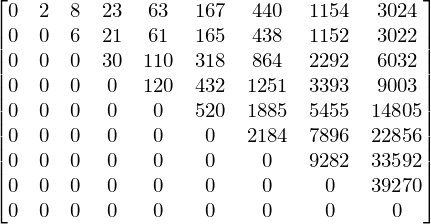

In [61]:
to_matrix_cost(dim=(9,9), memo_table=memo_table)

# `longest_common_subsequence`

In [211]:
@memo_holder
def longest_common_subsequence(A, B, gap_A, gap_B, 
                               equal=lambda a, b: 1, shrink_A=lambda a: 0, shrink_B=lambda b: 0,
                               reduce=sum):
    
    T = {}
    
    T.update({(i, 0):([gap_A]*i, 0) for i in range(len(A)+1)})
    T.update({(0, j):([gap_B]*j, 0) for j in range(len(B)+1)})
    
    def combine(w, z):
        alpha, beta = zip(w, z)
        return list(chain.from_iterable(alpha)), reduce(beta)
    
    for i, a in enumerate(A, start=1):
        for j, b in enumerate(B, start=1):
            T[i, j] = combine(T[i-1, j-1], ([a], equal(a, b))) if a == b else max(
                combine(T[i, j-1], ([gap_B], -shrink_B(b))), 
                combine(T[i-1, j], ([gap_A], -shrink_A(a))),
                key=lambda t: t[-1])
    
    opt, cost = T[len(A), len(B)]
    return (opt, cost), T

def pprint_memo_table(T, joiner, do=str):
    return {k:(joiner.join(map(do, v[0])), v[1]) for k, v in T.items()}

In [224]:
(opt, cost), memo_table = longest_common_subsequence(A='ADCAAB', 
                                                     B='BAABDCDCAACACBA', gap_A='▢', gap_B='○', 
                                                     #shrink_B=lambda b:1,
                                                     memo_table=True)

In [225]:
print('BAABDCDCAACACBA') 
print(''.join(opt))

BAABDCDCAACACBA
○○A○○○DC○A○A○B○


In [226]:
pprint_memo_table(memo_table, joiner='')

{(0, 0): ('', 0),
 (0, 1): ('○', 0),
 (0, 2): ('○○', 0),
 (0, 3): ('○○○', 0),
 (0, 4): ('○○○○', 0),
 (0, 5): ('○○○○○', 0),
 (0, 6): ('○○○○○○', 0),
 (0, 7): ('○○○○○○○', 0),
 (0, 8): ('○○○○○○○○', 0),
 (0, 9): ('○○○○○○○○○', 0),
 (0, 10): ('○○○○○○○○○○', 0),
 (0, 11): ('○○○○○○○○○○○', 0),
 (0, 12): ('○○○○○○○○○○○○', 0),
 (0, 13): ('○○○○○○○○○○○○○', 0),
 (0, 14): ('○○○○○○○○○○○○○○', 0),
 (0, 15): ('○○○○○○○○○○○○○○○', 0),
 (1, 0): ('▢', 0),
 (1, 1): ('▢○', 0),
 (1, 2): ('○A', 1),
 (1, 3): ('○○A', 1),
 (1, 4): ('○○A○', 1),
 (1, 5): ('○○A○○', 1),
 (1, 6): ('○○A○○○', 1),
 (1, 7): ('○○A○○○○', 1),
 (1, 8): ('○○A○○○○○', 1),
 (1, 9): ('○○○○○○○○A', 1),
 (1, 10): ('○○○○○○○○○A', 1),
 (1, 11): ('○○○○○○○○○A○', 1),
 (1, 12): ('○○○○○○○○○○○A', 1),
 (1, 13): ('○○○○○○○○○○○A○', 1),
 (1, 14): ('○○○○○○○○○○○A○○', 1),
 (1, 15): ('○○○○○○○○○○○○○○A', 1),
 (2, 0): ('▢▢', 0),
 (2, 1): ('▢▢○', 0),
 (2, 2): ('○A▢', 1),
 (2, 3): ('○A▢○', 1),
 (2, 4): ('○A▢○○', 1),
 (2, 5): ('○○A○D', 2),
 (2, 6): ('○○A○D○', 2),
 (2, 7): ('○○A○○

In [215]:
(opt, cost), memo_table = longest_common_subsequence(A=[0,1,1,2,3,5,8,13,21,34,55], 
                                                     B=[1, 1, 2, 5, 14, 42, 132, 429, 1430, 4862, 16796, 58786, 208012, 742900, 2674440,], 
                                                     gap_A='▢', gap_B='○', 
                                                     #shrink_B=lambda b:1,
                                                     memo_table=True)

In [216]:
print(','.join(map(str, opt)))

▢,1,1,2,▢,5,▢,▢,▢,▢,▢,○,○,○,○,○,○,○,○,○,○,○


In [217]:
pprint_memo_table(memo_table, joiner=',')

{(0, 0): ('', 0),
 (0, 1): ('○', 0),
 (0, 2): ('○,○', 0),
 (0, 3): ('○,○,○', 0),
 (0, 4): ('○,○,○,○', 0),
 (0, 5): ('○,○,○,○,○', 0),
 (0, 6): ('○,○,○,○,○,○', 0),
 (0, 7): ('○,○,○,○,○,○,○', 0),
 (0, 8): ('○,○,○,○,○,○,○,○', 0),
 (0, 9): ('○,○,○,○,○,○,○,○,○', 0),
 (0, 10): ('○,○,○,○,○,○,○,○,○,○', 0),
 (0, 11): ('○,○,○,○,○,○,○,○,○,○,○', 0),
 (0, 12): ('○,○,○,○,○,○,○,○,○,○,○,○', 0),
 (0, 13): ('○,○,○,○,○,○,○,○,○,○,○,○,○', 0),
 (0, 14): ('○,○,○,○,○,○,○,○,○,○,○,○,○,○', 0),
 (0, 15): ('○,○,○,○,○,○,○,○,○,○,○,○,○,○,○', 0),
 (1, 0): ('▢', 0),
 (1, 1): ('▢,○', 0),
 (1, 2): ('▢,○,○', 0),
 (1, 3): ('▢,○,○,○', 0),
 (1, 4): ('▢,○,○,○,○', 0),
 (1, 5): ('▢,○,○,○,○,○', 0),
 (1, 6): ('▢,○,○,○,○,○,○', 0),
 (1, 7): ('▢,○,○,○,○,○,○,○', 0),
 (1, 8): ('▢,○,○,○,○,○,○,○,○', 0),
 (1, 9): ('▢,○,○,○,○,○,○,○,○,○', 0),
 (1, 10): ('▢,○,○,○,○,○,○,○,○,○,○', 0),
 (1, 11): ('▢,○,○,○,○,○,○,○,○,○,○,○', 0),
 (1, 12): ('▢,○,○,○,○,○,○,○,○,○,○,○,○', 0),
 (1, 13): ('▢,○,○,○,○,○,○,○,○,○,○,○,○,○', 0),
 (1, 14): ('▢,○,○,○,○,○,○,○,○

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.